In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, learning_curve
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

# %matplotlib notebook
plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

$\textbf{Answer :}$

The primal problem with soft margins and feature map $\Phi$ is :
$$
\begin{array}{l}
    \displaystyle \mathop{\text{minimize}}_{\mathbf{w} \in \mathcal{H}, \, w_0 \in \mathbb{R}, \, \xi \in \mathbb{R}^n} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \\
    \quad \text{subject to} \quad \forall i, \xi_i \ge 0 \text{ and } y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0) \ge 1 - \xi_i 
\end{array}
$$

What we notice is that when $\Phi(x_i)$ is in the right side of the hyperplane ($i.e.$ when $y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0) \ge 1)$ then the only constraint on $\xi_i$ is to be non-negative so that we will get $\xi_i^*=0$. 

When this is not the case, the constraint on $\xi_i$ is $\xi_i \ge 1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)$ and then $\xi_i^* = 1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)$. 

To conclude, we have that $$\forall i, \xi_i^* = \max(0, 1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}\rangle + w_0)) = \left[1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}\rangle + w_0)\right]_+$$

We then just need to subtitute this expression in the primal problem to get what we wanted. 

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

$\textbf{Answer :}$

When an SVM solves the primal problem, it aims to minimize the following function :
$$f(\mathbf{w}, w_0) = \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^n \mathrm{Hinge}\left[y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)\right]$$

The *Hinge* function is convex and is an upper bound of the binary classification error (which is equal to 1 if the point is not correctly classified and 0 otherwise). In the sentence, the "convex upper bound" is just the hinge loss, which is minimized by the SVM when solving the primal problem.

There are many differences between these two losses :
- the hinge loss is continuous and convex therefore easier to optimize
- the hinge loss penalizes points which are correctly classified but still too close to the hyperplane, contrary to the binary loss
- if a point is not correctly classified, the binary loss will just assign a constant loss to it when the hinge loss will penalize it in proportion to it's distance from the hyperplane.

## Example of using SVC (originally in ```svm_script.py```)

In [3]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

Score : 0.8


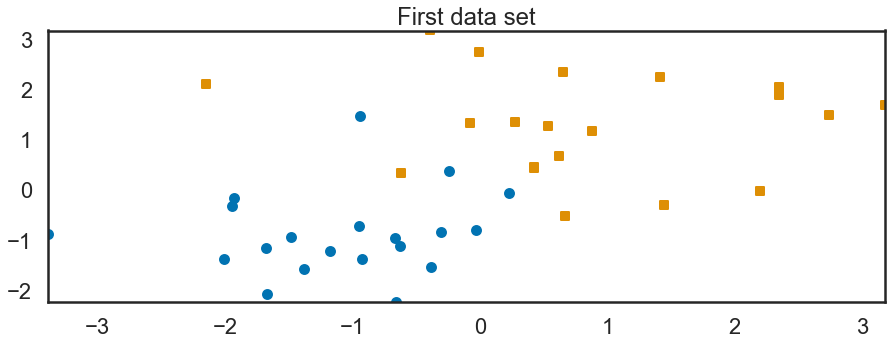

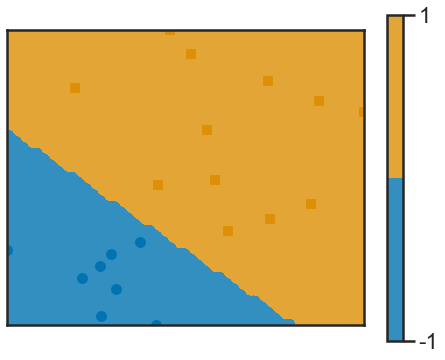

In [4]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

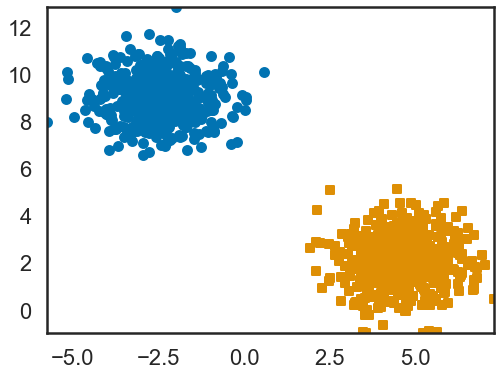

In [5]:
seed = 42
rng = np.random.RandomState(seed)

X, y, centers = make_blobs(n_samples=1000, centers=2, return_centers=True, random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
plot_2d(X, y)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

The expression of the Bayes risk is $\mathbb{E}\left[\min\left(\eta(X), 1-\eta(X)\right)\right]$ where $\eta(X) = \mathbb{P}(Y=1|X)$. To approximate this expression, we will use a Monte-Carlo estimator $$\hat R = \frac{1}{n_{MC}}\sum_{i = 1}^{n_{MC}}\min\left(\eta(X_i), 1-\eta(X_i)\right)$$
by choosing $n_{MC}$ i.i.d. samples equal in law to $YX_1 + (1-Y)X_{-1}$ where $X_1, X_{-1}, Y$ are independant with respective probability laws $\mathcal{N}_1, \mathcal{N}_{-1}, \mathrm{Ber}\left(\frac{1}{2}\right)$ ($\mathcal{N}_1$ is the law of the first blob, $\mathcal{N}_{-1}$ the law of the second). We can also compute that $\eta(x)=\frac{f_1(x)}{f_1(x)+f_{-1}(x)}$.

In [6]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

def MCestim_bayes(n) :
    s = 0
    for i in range(n) :
        u = np.random.random()
        if u < 0.5 :
            x = np.random.multivariate_normal(centers[0], np.identity(2))
        else :
            x = np.random.multivariate_normal(centers[1], np.identity(2))
        a = multivariate_normal.pdf(x, centers[0])
        b = multivariate_normal.pdf(x, centers[1])
        eta = a/(a+b)
        s += min(eta, 1 - eta)
    return s/n

In [7]:
n = 1000

print(f"Estimated bayes risk with {n} iterations : {MCestim_bayes(n)}")

Estimated bayes risk with 1000 iterations : 5.187609579517278e-10


**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/1.0/auto_examples/svm/plot_separating_hyperplane.html.

In [73]:
def plot_boundary(X, y, estimator, support_vectors=False) :
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = estimator.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(
        XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
    )
    
    if(support_vectors) :
        ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
        )
    plt.show()

In [9]:
# Fit the model

clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X_train, y_train)

SVC(C=1000, kernel='linear')

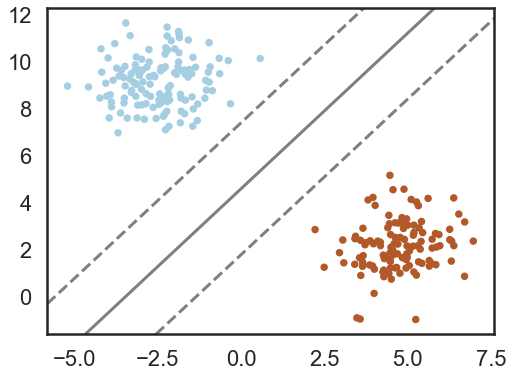

In [10]:
# Show the result on test data

plot_boundary(X_test, y_test, clf)

In [11]:
clf = svm.SVC(kernel="linear", C=0.001)
clf.fit(X_train, y_train)

SVC(C=0.001, kernel='linear')

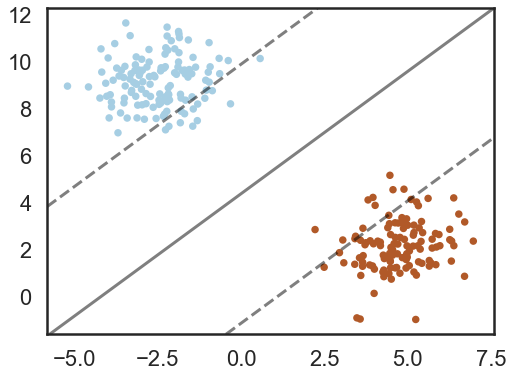

In [12]:
plot_boundary(X_test, y_test, clf)

$\textbf{Answer :}$

We notice that we get more support vectors (*i.e.* errors) when C is small. Such a result is expected because the hyperparameter C quantifies the importance we give to the constraints when maximizing the margin.

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

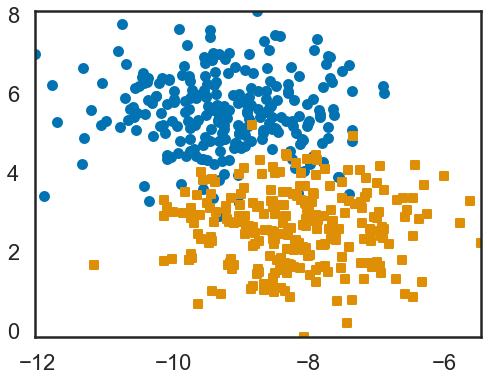

In [13]:
# Generate data and verify graphically that the two classes overlap

seed = 34
rng = np.random.RandomState(seed)

X, y, centers = make_blobs(n_samples=500, centers=2, return_centers=True, random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
plot_2d(X, y)
plt.show()

In [14]:
# Find the best working C with a 5-fold cross-validation

cvf = svm.SVC(kernel="linear")
C_grid = [10**i for i in range(-3, 4)]
param_grid = {'C': C_grid}

gs = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [15]:
C_opt = gs.best_params_.get('C')
print(f"The best value of C found is {C_opt} with a score of {gs.best_score_}.")

The best value of C found is 100 with a score of 0.9546666666666667.


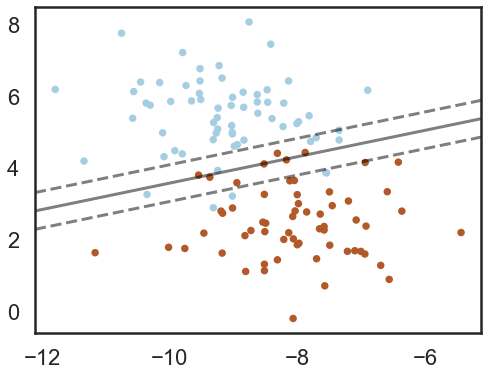

In [16]:
plot_boundary(X_test, y_test, gs.best_estimator_)

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

$\textbf{Answer :}$

If we choose bad intervals for out parameters when doing the grid search and if we don't pay too much attention to the cross validation score, we can overfit the training data quite heavily.

In [17]:
# Vary the parameter of the kernel and check the difference between training and testing scores

cvf = svm.SVC()
C_grid = np.arange(0, 100, 5)
gamma_grid = np.arange(200, 300, 5)
param_grid = [{'C': C_grid, 'gamma': gamma_grid, 'kernel': ['rbf']}]

gs = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid=[{'C': array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95]),
                          'gamma': array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295]),
                          'kernel': ['rbf']}])

In [18]:
print(gs.best_params_, gs.best_score_)

{'C': 5, 'gamma': 200, 'kernel': 'rbf'} 0.7866666666666666


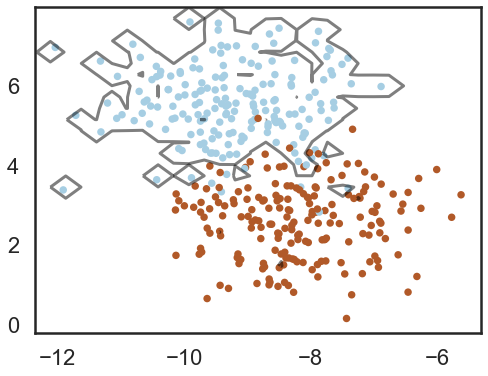

In [19]:
plot_boundary(X_train, y_train, gs.best_estimator_)

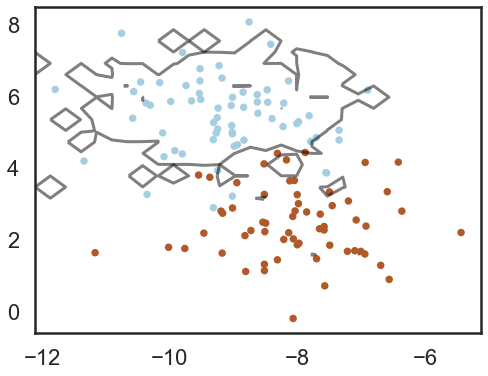

In [20]:
plot_boundary(X_test, y_test, gs.best_estimator_)

In [21]:
print(f"Score on train data : {gs.best_estimator_.score(X_train, y_train)}")
print(f"Score on test data : {gs.best_estimator_.score(X_test, y_test)}")

Score on train data : 1.0
Score on test data : 0.8


## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

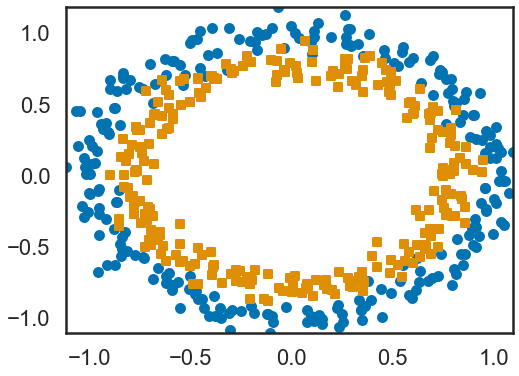

In [22]:
seed = 42
rng = np.random.RandomState(seed)

X, y = make_circles(n_samples=500, noise = 0.06, random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
plot_2d(X, y)

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

In [23]:
cvf = svm.SVC()
C_grid = np.arange(0, 100, 5)
gamma_grid = np.arange(0,100, 5)
param_grid = [{'C': C_grid, 'gamma': gamma_grid, 'kernel': ['rbf']}]

gs_gaussian = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs_gaussian.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid=[{'C': array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95]),
                          'gamma': array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95]),
                          'kernel': ['rbf']}])

In [24]:
cvf = svm.SVC()
coef0_grid = [10**i for i in range(-4, 4)]
degree_grid = np.arange(1, 3, 1)
gamma_grid = [10**i for i in range(-4, 4)]
param_grid = [{'coef0': coef0_grid, 'gamma': gamma_grid, 'degree' : degree_grid, 'kernel': ['poly']}]

gs_poly = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs_poly.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid=[{'coef0': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'degree': array([1, 2]),
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['poly']}])

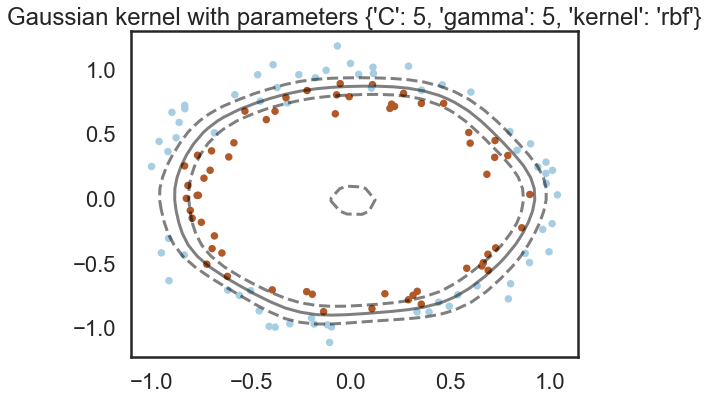

In [25]:
plt.title(f"Gaussian kernel with parameters {gs_gaussian.best_params_}")
plot_boundary(X_test, y_test, gs_gaussian.best_estimator_)

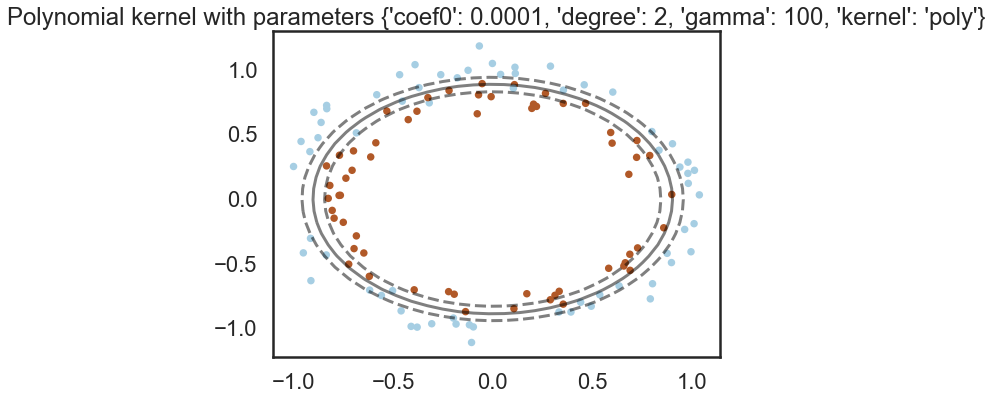

In [26]:
plt.title(f"Polynomial kernel with parameters {gs_poly.best_params_}")
plot_boundary(X_test, y_test, gs_poly.best_estimator_)

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

$\textbf{Answer :}$

We will compare the performance of different kernels with a fixed dataset (generated using the `make_circles` function) in the following way :
- first, we split the dataset in train and test,
- then, we perform a grid search to find good hyperparameters,
- we fit the corresponding classifier,
- finally, we evaluate its accuracy on the test set to prevent from overfitting.

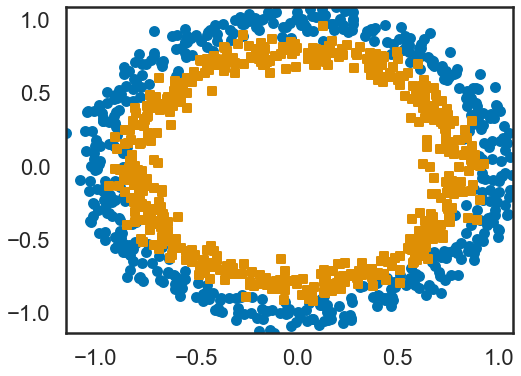

In [27]:
seed = 42
rng = np.random.RandomState(seed)

X, y = make_circles(n_samples=1000, noise = 0.06, random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
plot_2d(X, y)

In [28]:
cvf = svm.SVC(kernel="linear")
C_grid = [10**i for i in range(-4, 3)]
param_grid = {'C': C_grid}

gs_linear = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs_linear.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]})

In [29]:
print(gs_linear.best_params_, gs_linear.best_score_)

{'C': 0.0001} 0.5080000000000001


For the linear classifier, the best value for C seems to be the smallest value in the grid. Plus, the score doesn't seem to get better than 50%. This is completely normal considering the best linear separator we have with this specific dataset is the diameter of one of the circles. 

In [30]:
cvf = svm.SVC()
coef0_grid = np.arange(1,10,1)
degree_grid = np.arange(1, 3, 1)
gamma_grid = np.arange(80,90,1)
param_grid = [{'coef0': coef0_grid, 'gamma': gamma_grid, 'degree' : degree_grid, 'kernel': ['poly']}]

gs_poly = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs_poly.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid=[{'coef0': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'degree': array([1, 2]),
                          'gamma': array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
                          'kernel': ['poly']}])

In [31]:
print(gs_poly.best_params_, gs_poly.best_score_)

{'coef0': 3, 'degree': 2, 'gamma': 88, 'kernel': 'poly'} 0.9480000000000001


In [32]:
cvf = svm.SVC()
C_grid = np.arange(0, 10, 1)
gamma_grid = np.arange(0,3, 0.1)
param_grid = [{'C': C_grid, 'gamma': gamma_grid, 'kernel': ['rbf']}]

gs_gaussian = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs_gaussian.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid=[{'C': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9]),
                          'kernel': ['rbf']}])

In [33]:
print(gs_gaussian.best_params_, gs_gaussian.best_score_)

{'C': 3, 'gamma': 0.4, 'kernel': 'rbf'} 0.9493333333333333


In [34]:
print("Score for linear kernel on test set : ", gs_linear.best_estimator_.score(X_test, y_test))
print("Score for polynomial kernel on test set : ", gs_poly.best_estimator_.score(X_test, y_test))
print("Score for gaussian kernel on test set : ", gs_gaussian.best_estimator_.score(X_test, y_test))

Score for linear kernel on test set :  0.476
Score for polynomial kernel on test set :  0.948
Score for gaussian kernel on test set :  0.948


It seems that for this specific dataset, gaussian and polynomial kernels are equivalent. However, the data is not linearly separable and the linear kernal's performance are very weak.

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

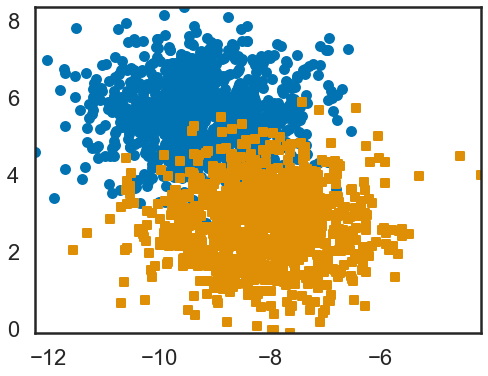

In [35]:
seed = 34
rng = np.random.RandomState(seed)

X, y, centers = make_blobs(n_samples=2000, centers=2, return_centers=True, random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
plot_2d(X, y)
plt.show()

In [36]:
cvf = svm.SVC()
C_grid = np.arange(0, 0.1, 0.01)
gamma_grid = np.arange(0.4, 0.6, 0.01)
param_grid = [{'C': C_grid, 'gamma': gamma_grid, 'kernel': ['rbf']}]

gs = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(C=0.001, kernel='linear'), n_jobs=-1,
             param_grid=[{'C': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                          'gamma': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]),
                          'kernel': ['rbf']}])

In [37]:
print(gs.best_params_, gs.best_score_)

{'C': 0.03, 'gamma': 0.4, 'kernel': 'rbf'} 0.9339999999999999


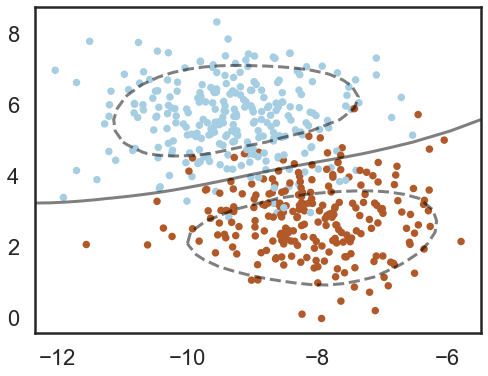

In [38]:
plot_boundary(X_test, y_test, gs.best_estimator_)

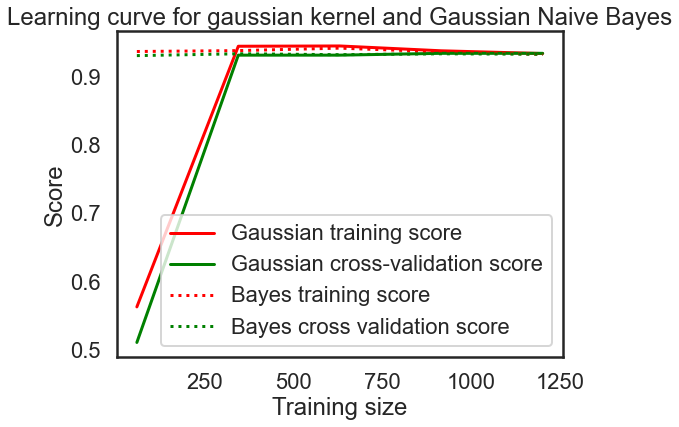

In [39]:
train_sizes = np.linspace(0.05, 1.0, 5)

train_sizes, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=train_sizes, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Gaussian training score", color="r")
plt.plot(train_sizes, test_scores_mean, label="Gaussian cross-validation score", color="g")

train_sizes, train_scores, test_scores = learning_curve(GaussianNB(), X_train, y_train, train_sizes=train_sizes, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, linestyle='dotted', c='r', label="Bayes training score")
plt.plot(train_sizes, test_scores_mean, linestyle='dotted', c='g', label="Bayes cross validation score")

plt.title("Learning curve for gaussian kernel and Gaussian Naive Bayes")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.legend()
plt.show()

For small amounts of data, both the training score and the validation score of the SVM are low therefore adding more training samples will increase generalization and performance. However this is not the case for the Bayes classifier for which the amount of data doesn't seem to increase generalization.

**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


$\textbf{Answer :}$

We've seen previously that when $C$ gets smaller we have more support vectors (and conversly) so it is equivalent to draw these graphs as a function of $C$.

In [40]:
# Modify the class of some data points randomly

nb = 100
ii = np.random.randint(0, y_train.size, nb)
for i in ii:
    y_train[i] = 1 - y_train[i]

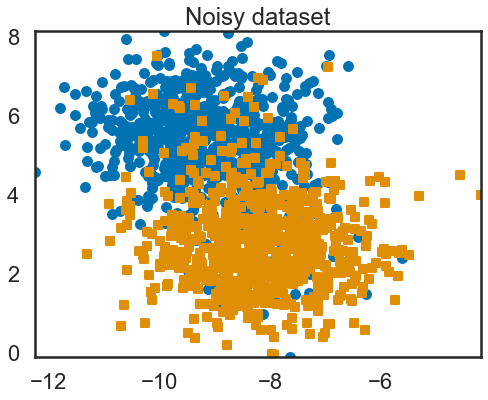

In [41]:
plt.title("Noisy dataset")
plot_2d(X_train, y_train)

In [50]:
clf = svm.SVC(kernel="rbf")
cc = np.linspace(1e-4, 0.03, num=50)
train_scores = []
test_scores = []

for C in cc:
    clf.set_params(**{"C": C})
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

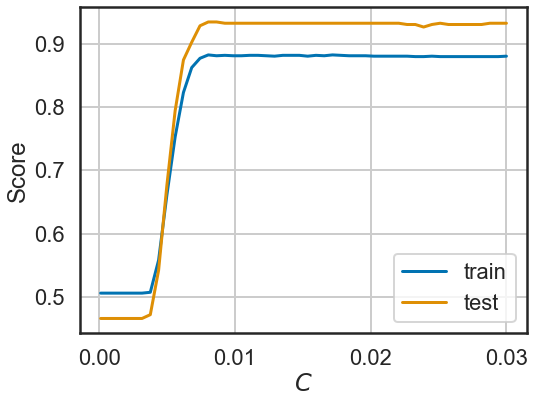

In [58]:
plt.plot(Cs, train_scores, label="train")
plt.plot(Cs, test_scores, label="test")
plt.xlabel(r"$C$")
plt.ylabel("Score")
plt.grid()
plt.legend()
plt.show()

In [83]:
clf.set_params(**{"C": 0.001})
clf.fit(X_train, y_train)

SVC(C=0.001)

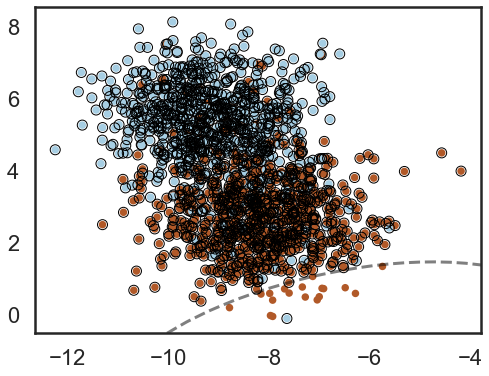

In [84]:
plot_boundary(X_train, y_train, clf, support_vectors=True)

In [87]:
clf.set_params(**{"C": 0.01})
clf.fit(X_train, y_train)

SVC(C=0.01)

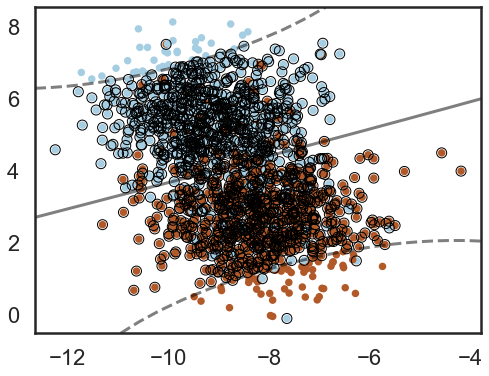

In [88]:
plot_boundary(X_train, y_train, clf, support_vectors=True)

We can see there is a turning point at, say, $C_0$. Before $C_0$, the constraint on the slack variables is too weak and the noise has an important influence on the way the model fits the data. This results in a poor score overall but also a weaker generalisation as the test scores are smaller than the train scores. However, as soon as $C$ exceeds $C_0$ the trend reverses and the model both performs and generalizes quite well.

## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regula-
rization parameter C.

It didn't matter how much I tried, I never could run the script (I tried running it local, on colab, using binder, changing `stable` to `1.0` in the link and nothing worked, either I got this error `ipykernel_launcher.py: error: no such option: -f` or that one `ImportError: Cannot load backend ‘TkAgg’ which requires the ‘tk’ interactive framework, as ‘headless’ is currently running` and could solve neither of those...). I will therefore try to answer the question 15 without the script.

**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

As $C$ decreases, the number of support vectors is going to increase until eventually all the point of the under-represented class are support vectors. At this point, the penalization attributed to these under-represented points will be roughly the same wether they are on the right or the left side of the hyperplane (because $C$ is small). However, there is one solution that will lead to having a lot of over-represented points as support vectors when the other will not. Because we are effectively doing a minimization, the other solution will be chosen : all the points are going to be on one side of the hyperplane, regardless of their class.

## Going further : application to face classification

Code for downloading and organizing the data:

In [ ]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

**18)** Explain why the features are centered and reduced.

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.